In [1]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, optim 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import cycle
from collections import Counter
%matplotlib inline
import random
from torch.utils import data
import os
from tqdm import tqdm
from pyDOE import lhs

In [2]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True

In [3]:
data_x=pd.read_csv("one_data_x_new.csv")
data_t=pd.read_csv("one_data_t_new.csv")

In [4]:
h10_x=data_x.iloc[:, [0]]#初值x,t
h10_t=data_x.iloc[:, [1]]
h10_R=data_x.iloc[:,[2]]#初值h实部
h10_C=data_x.iloc[:,[3]]#初值h虚部
hb_x1=data_t.iloc[:,[1]]#边值-5，t
hb_t1=data_t.iloc[:,[0]]
hb_x2=data_t.iloc[:,[2]]#边值5，t
hb_t2=data_t.iloc[:,[0]]

h20_x=data_x.iloc[:, [0]]#初值x,t
h20_t=data_x.iloc[:, [1]]
h20_R=data_x.iloc[:,[4]]#初值h实部
h20_C=data_x.iloc[:,[5]]#初值h虚部

# h30_x=data_xx.iloc[:, [0]]
# h30_t=data_xx.iloc[:, [1]]
# h30_r1=data_xx.iloc[:, [2]]
# h30_c1=data_xx.iloc[:, [3]]
# h30_r2=data_xx.iloc[:, [4]]
# h30_c2=data_xx.iloc[:, [5]]

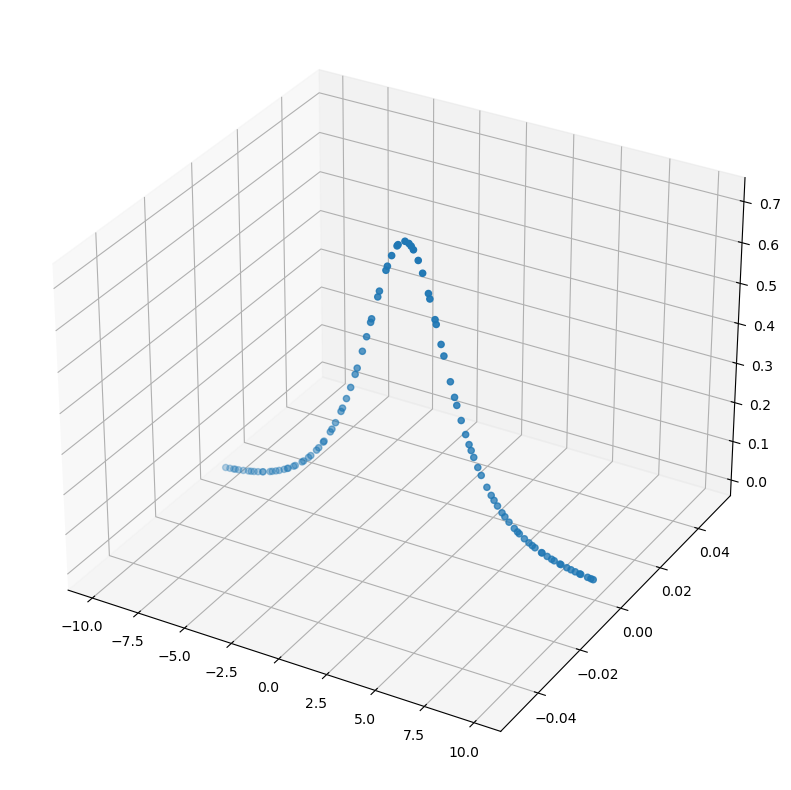

In [5]:
plt.figure(figsize=(10, 10))
bx = plt.axes(projection='3d')
bx.scatter3D(h10_x,h10_t,h10_R, label='Initial')


In [6]:
n=60
x=lhs(1,samples=n)*20-10
t=lhs(1,samples=n)*4-2
X, T = np.meshgrid(x,t)
hf= np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
hf_x=hf[:,[0]]
hf_t=hf[:,[1]]

In [7]:
train10_x,test10_x,train10_t,test10_t,train10_r,test10_r,train10_c,test10_c,trainb_x1,testb_x1,trainb_t1,testb_t1,trainb_x2,testb_x2,trainb_t2,testb_t2,train20_r,test20_r,train20_c,test20_c = train_test_split(h10_x,h10_t,h10_R,h10_C,hb_x1,hb_t1,hb_x2,hb_t2,h20_R,h20_C,test_size=0.2)

# train30_x,test30_x,train30_t,test30_t,train30_r1,test30_r1,train30_c1,test30_c1,train30_r2,test30_r2,train30_c2,test30_c2=train_test_split(h30_x,h30_t,h30_r1,h30_c1,h30_r2,h30_c2)


In [8]:
trainu_x, testu_x, trainu_t, testu_t = train_test_split(hf_x, hf_t, test_size=0.2)



In [9]:
train10_x=torch.from_numpy(train10_x.to_numpy()).float()
train10_t=torch.from_numpy(train10_t.to_numpy()).float()

train10_r=torch.from_numpy(train10_r.to_numpy()).float()
train10_c=torch.from_numpy(train10_c.to_numpy()).float()

trainb_x1=torch.from_numpy(trainb_x1.to_numpy()).float()
trainb_t1=torch.from_numpy(trainb_t1.to_numpy()).float()
trainb_x2=torch.from_numpy(trainb_x2.to_numpy()).float()
trainb_t2=torch.from_numpy(trainb_t2.to_numpy()).float()

# train20_x=torch.from_numpy(train20_x.to_numpy()).float()
# train20_t=torch.from_numpy(train20_t.to_numpy()).float()
train20_r=torch.from_numpy(train20_r.to_numpy()).float()
train20_c=torch.from_numpy(train20_c.to_numpy()).float()


# train30_x=torch.from_numpy(train30_x.to_numpy()).float()
# train30_t=torch.from_numpy(train30_t.to_numpy()).float()
# train30_r1=torch.from_numpy(train30_r1.to_numpy()).float()
# train30_c1=torch.from_numpy(train30_c1.to_numpy()).float()
# train30_r2=torch.from_numpy(train30_r2.to_numpy()).float()
# train30_c2=torch.from_numpy(train30_c2.to_numpy()).float()

trainu_x=torch.from_numpy(trainu_x).float()
trainu_t=torch.from_numpy(trainu_t).float()

In [10]:
test10_x=torch.from_numpy(test10_x.to_numpy()).float()
test10_t=torch.from_numpy(test10_t.to_numpy()).float()
test10_r=torch.from_numpy(test10_r.to_numpy()).float()
test10_c=torch.from_numpy(test10_c.to_numpy()).float()

testb_x1=torch.from_numpy(testb_x1.to_numpy()).float()
testb_t1=torch.from_numpy(testb_t1.to_numpy()).float()
testb_x2=torch.from_numpy(testb_x2.to_numpy()).float()
testb_t2=torch.from_numpy(testb_t2.to_numpy()).float()

# test20_x=torch.from_numpy(test20_x.to_numpy()).float()
# test20_t=torch.from_numpy(test20_t.to_numpy()).float()
test20_r=torch.from_numpy(test20_r.to_numpy()).float()
test20_c=torch.from_numpy(test20_c.to_numpy()).float()

testu_x=torch.from_numpy(testu_x).float()
testu_t=torch.from_numpy(testu_t).float()

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:
class DNN(torch.nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 100),
            torch.nn.SiLU(),
            torch.nn.Linear(100, 100),
            torch.nn.SiLU(),
            torch.nn.Linear(100, 100),
            torch.nn.SiLU(),    
            torch.nn.Linear(100, 100),
            torch.nn.SiLU(),    
            torch.nn.Linear(100, 100),
            torch.nn.SiLU(),
            torch.nn.Linear(100, 100),
            torch.nn.SiLU(),
            torch.nn.Linear(100, 4)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
import sys


class PhysicsInformedNN():
    def __init__(self, u10_x, u10_t, u10_r, u10_c, ub_x1, ub_t1, ub_x2, ub_t2, u20_r, u20_c, uf_x, uf_t):
        self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
        self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
        self.u10_r = torch.tensor(u10_r, requires_grad=True).float().to(device)
        self.u10_c = torch.tensor(u10_c, requires_grad=True).float().to(device)
        
        self.ub_x1 = torch.tensor(ub_x1, requires_grad=True).float().to(device)
        self.ub_x2 = torch.tensor(ub_x2, requires_grad=True).float().to(device)
        self.ub_t1 = torch.tensor(ub_t1, requires_grad=True).float().to(device)
        self.ub_t2 = torch.tensor(ub_t2, requires_grad=True).float().to(device)
        
#         self.u20_x = u20_x.clone().detach().requires_grad_(True).float().to(device)
#         self.u20_t = torch.tensor(u20_t, requires_grad=True).float().to(device)
        self.u20_r = torch.tensor(u20_r, requires_grad=True).float().to(device)
        self.u20_c = torch.tensor(u20_c, requires_grad=True).float().to(device)
        
        # self.u30_x = torch.tensor(u30_x, requires_grad=True).float().to(device)
        # self.u30_t = torch.tensor(u30_t, requires_grad=True).float().to(device)
        # self.u30_r1 = torch.tensor(u30_r1, requires_grad=True).float().to(device)
        # self.u30_c1 = torch.tensor(u30_c1, requires_grad=True).float().to(device)
        # self.u30_r2 = torch.tensor(u30_r2, requires_grad=True).float().to(device)
        # self.u30_c2 = torch.tensor(u30_c2, requires_grad=True).float().to(device)
      
        
        self.uf_x = torch.tensor(uf_x,requires_grad=True).float().to(device)
        self.uf_t = torch.tensor(uf_t,requires_grad=True).float().to(device)
        
        # self.lambda_1 = torch.tensor([0.9], requires_grad=True).to(device)
        # self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        # #self.lambda_5 = torch.tensor([0.9], requires_grad=True).to(device)
        # #self.lambda_5 = torch.nn.Parameter(self.lambda_5)
        
        # self.lambda_2 = torch.tensor([0.8], requires_grad=True).to(device)
        # self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        #self.lambda_6 = torch.tensor([2.2], requires_grad=True).to(device)
        #self.lambda_6 = torch.nn.Parameter(self.lambda_6)

        
        self.dnn = DNN().to(device)
        self.optimizer = torch.optim.Adam([
            {'params':self.dnn.parameters()},
            #{'params': [self.lambda_1], 'lr': 0.00002},
            #{'params': [self.lambda_2], 'lr': 0.00002},
            #{'params': [self.lambda_5], 'lr': 0.0002},
            #{'params': [self.lambda_6], 'lr': 0.0001}

        ],lr=0.0005)

        self.optimizer1 = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=10000, 
            max_eval=20000, 
            history_size=10,
            tolerance_grad=1e-8   , 
            tolerance_change=1.0 * np.finfo(float).eps,
            #line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.iter = 0
    
        self.losshistory=[]
    def net_u(self, x, t):  
        u1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,0],1)
        v1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,1],1)
        u2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,2],1)
        v2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,3],1)
        return u1, v1, u2, v2

    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        beta=1
        lambda_1 = 1
        lambda_2 = 2
        lambda_3 = -1
        lambda_4 = 0
        lambda_5 = 1#self.lambda_5
        lambda_6 = 2#self.lambda_6
        u1, v1,u2, v2= self.net_u(x, t)
        
        u1_t = torch.autograd.grad(
            u1, t, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_x = torch.autograd.grad(
            u1, x, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_xx = torch.autograd.grad(
            u1_x, x, 
            grad_outputs=torch.ones_like(u1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v1_t = torch.autograd.grad(
            v1, t, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_x = torch.autograd.grad(
            v1, x, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_xx = torch.autograd.grad(
            v1_x, x, 
            grad_outputs=torch.ones_like(v1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        
        u2_t = torch.autograd.grad(
            u2, t, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_x = torch.autograd.grad(
            u2, x, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_xx = torch.autograd.grad(
            u2_x, x, 
            grad_outputs=torch.ones_like(u2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v2_t = torch.autograd.grad(
            v2, t, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_x = torch.autograd.grad(
            v2, x, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_xx = torch.autograd.grad(
            v2_x, x, 
            grad_outputs=torch.ones_like(v2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f_u1 = (
            v1_t + u1_xx
        + lambda_1*u1*(u1**2 + v1**2) + lambda_2*u1*(u2**2 + v2**2) + lambda_3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + lambda_4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

        f_v1 = (
                -u1_t + v1_xx
            + lambda_1*v1*(u1**2 + v1**2) + lambda_2*v1*(u2**2 + v2**2) - lambda_3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - lambda_4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
        )

        f_u2 = (
                v2_t + beta*u2_xx
            + lambda_1*u2*(u2**2 + v2**2) + lambda_2*u2*(u1**2 + v1**2) + lambda_3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + lambda_4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
        )

        f_v2 = (
                -u2_t + beta*v2_xx
            + lambda_1*v2*(u2**2 + v2**2) + lambda_2*v2*(u1**2 + v1**2) - lambda_3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - lambda_4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
        )
        a=u1_x
        b=v1_x
        c=u2_x
        d=v2_x
        return f_u1, f_v1, f_u2, f_v2, a, b, c, d
     
    def loss_func(self):
        #for self.iter in tqdm(range(10000)):
        torch.cuda.empty_cache()
        self.optimizer1.zero_grad()

        u10_pred, v10_pred, u20_pred, v20_pred = self.net_u(self.u10_x,self.u10_t) 
        # u30_pred1, v30_pred1, u30_pred2, v30_pred2 = self.net_u(self.u30_x,self.u30_t)
        u1b_pred1, v1b_pred1, u2b_pred1, v2b_pred1 = self.net_u(self.ub_t1,self.ub_x1)
        u1b_pred2, v1b_pred2, u2b_pred2, v2b_pred2 = self .net_u(self.ub_t2,self.ub_x2)
        
        
        a1,b1,c1,d1,u1bx_pred1, v1bx_pred1,u2bx_pred1, v2bx_pred1 = self.net_f(self.ub_t1,self.ub_x1)
        a2,b2,c2,d2,u1bx_pred2, v1bx_pred2,u2bx_pred2, v2bx_pred2 = self.net_f(self.ub_t2,self.ub_x2)
        
        f_predu1, f_predv1, f_predu2, f_predv2,a1,b1,c1,d1 = self.net_f(self.uf_x,self.uf_t)
        
        loss_u0 = torch.mean((self.u10_r - u10_pred) ** 2)+torch.mean((self.u10_c - v10_pred) ** 2)+torch.mean((self.u20_r - u20_pred) ** 2)+torch.mean((self.u20_c - v20_pred) ** 2)
        loss_ub = torch.mean((u1b_pred1 - u1b_pred2) ** 2)+torch.mean((v1b_pred1 - v1b_pred2) ** 2)+torch.mean((u2b_pred1 - u2b_pred2) ** 2)+torch.mean((v2b_pred1 - v2b_pred2) ** 2)
        loss_ubx = torch.mean((u1bx_pred1 - u1bx_pred2) ** 2)+torch.mean((v1bx_pred1 - v1bx_pred2) ** 2)+torch.mean((u2bx_pred1 - u2bx_pred2) ** 2)+torch.mean((v2bx_pred1 - v2bx_pred2) ** 2)
        loss_f = torch.mean(f_predu1 ** 2)+torch.mean(f_predv1 ** 2)+torch.mean(f_predu2 ** 2)+torch.mean(f_predv2 ** 2)
        # loss_u1=torch.mean((self.u30_r1 - u30_pred1) ** 2)+torch.mean((self.u30_c1 - v30_pred1) ** 2)+torch.mean((self.u30_r2 - u30_pred2) ** 2)+torch.mean((self.u30_c2 - v30_pred2) ** 2)
        
        loss = 3*loss_f+loss_u0 + loss_ub + loss_ubx
        
        loss.backward()
        
        #self.losshistory.append(loss.clone().detach().cpu())
            
        self.iter += 1
        #with torch.no_grad():
        if self.iter % 500 == 0:
            print('Iter %d, Loss: %.5e, Loss_u0: %.5e, Loss_ub: %.5e, Loss_ubx: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u0.item(), loss_ub.item(), loss_ubx.item(), loss_f.item()))
            


        return float(loss)
        
 
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        for epoch in tqdm(range(2000)):

            u10_pred, v10_pred, u20_pred, v20_pred = self.net_u(self.u10_x,self.u10_t) 
            # u30_pred1, v30_pred1, u30_pred2, v30_pred2 = self.net_u(self.u30_x,self.u30_t)
            u1b_pred1, v1b_pred1, u2b_pred1, v2b_pred1 = self.net_u(self.ub_t1,self.ub_x1)
            u1b_pred2, v1b_pred2, u2b_pred2, v2b_pred2 = self .net_u(self.ub_t2,self.ub_x2)
            
            
            a1,b1,c1,d1,u1bx_pred1, v1bx_pred1,u2bx_pred1, v2bx_pred1 = self.net_f(self.ub_t1,self.ub_x1)
            a2,b2,c2,d2,u1bx_pred2, v1bx_pred2,u2bx_pred2, v2bx_pred2 = self.net_f(self.ub_t2,self.ub_x2)
            
            f_predu1, f_predv1, f_predu2, f_predv2,a1,b1,c1,d1 = self.net_f(self.uf_x,self.uf_t)
            
            loss_u0 = torch.mean((self.u10_r - u10_pred) ** 2)+torch.mean((self.u10_c - v10_pred) ** 2)+torch.mean((self.u20_r - u20_pred) ** 2)+torch.mean((self.u20_c - v20_pred) ** 2)
            loss_ub = torch.mean((u1b_pred1 - u1b_pred2) ** 2)+torch.mean((v1b_pred1 - v1b_pred2) ** 2)+torch.mean((u2b_pred1 - u2b_pred2) ** 2)+torch.mean((v2b_pred1 - v2b_pred2) ** 2)
            loss_ubx = torch.mean((u1bx_pred1 - u1bx_pred2) ** 2)+torch.mean((v1bx_pred1 - v1bx_pred2) ** 2)+torch.mean((u2bx_pred1 - u2bx_pred2) ** 2)+torch.mean((v2bx_pred1 - v2bx_pred2) ** 2)
            loss_f = torch.mean(f_predu1 ** 2)+torch.mean(f_predv1 ** 2)+torch.mean(f_predu2 ** 2)+torch.mean(f_predv2 ** 2)
            # loss_u1=torch.mean((self.u30_r1 - u30_pred1) ** 2)+torch.mean((self.u30_c1 - v30_pred1) ** 2)+torch.mean((self.u30_r2 - u30_pred2) ** 2)+torch.mean((self.u30_c2 - v30_pred2) ** 2)
            
            loss = 2*loss_f+loss_u0*0.5+ loss_ub + loss_ubx
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            # if loss<self.best_loss:
            #     self.best_loss=loss.item()
            #     self.best_lambda_1=self.lambda_1.item()
            #     self.best_lambda_2=torch.exp(self.lambda_2.detach()).item()
            if epoch % 500 == 0 and epoch != 0:
                print('Iter %d, Loss: %.5e, Loss_u0: %.5e, Loss_ub: %.5e, Loss_ubx: %.5e, Loss_f: %.5e' % (epoch, loss.item(), loss_u0.item(), loss_ub.item(), loss_ubx.item(), loss_f.item()))
                u10_pred, v10_pred, u20_pred, v20_pred = self.net_u(self.uf_x,self.uf_t) 
                plt.figure(figsize=(10, 10))
                bx = plt.axes(projection='3d')
                bx.scatter3D(self.uf_x.cpu().detach(),self.uf_t.cpu().detach(),np.sqrt(u10_pred.cpu().detach()**2+v10_pred.cpu().detach()**2), label='Initial')
                #sys.exit()


        self.optimizer1.step(self.loss_func)
    def predict1(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        u1, v1 , u2, v2= self.net_u(x, t)
        u1 = u1.detach().cpu().numpy()
        v1 = v1.detach().cpu().numpy()
        u2 = u2.detach().cpu().numpy()
        v2 = v2.detach().cpu().numpy()
        
        return u1, v1, u2, v2
    
    def predict2(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        f1, f2, f3, f4, a, b, c, d = self.net_f(x, t)
        f1 = f1.detach().cpu().numpy()
        f2 = f2.detach().cpu().numpy()
        f3 = f3.detach().cpu().numpy()
        f4 = f4.detach().cpu().numpy()
        return  f1, f2, f3, f4, a, b, c, d

In [14]:


model = PhysicsInformedNN(train10_x, train10_t, train10_r, train10_c, 
                          trainb_x1, trainb_t1, trainb_x2, trainb_t2,
                        train20_r, train20_c, trainu_x, trainu_t)




C:\Users\npofsi\AppData\Local\Temp\ipykernel_18624\4110178622.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_18624\4110178622.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_18624\4110178622.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_r = torch.tensor(u10_r, requires_grad=True).float

 25%|██▌       | 501/2000 [01:35<05:24,  4.63it/s]

Iter 500, Loss: 2.43235e-02, Loss_u0: 2.98809e-02, Loss_ub: 3.85751e-04, Loss_ubx: 7.82347e-05, Loss_f: 4.45951e-03


 50%|█████     | 1002/2000 [03:04<02:57,  5.63it/s]

Iter 1000, Loss: 2.34586e-02, Loss_u0: 2.78161e-02, Loss_ub: 2.85655e-04, Loss_ubx: 7.88657e-05, Loss_f: 4.59300e-03


 75%|███████▌  | 1501/2000 [04:29<01:31,  5.43it/s]

Iter 1500, Loss: 2.33127e-02, Loss_u0: 2.76133e-02, Loss_ub: 2.05262e-04, Loss_ubx: 6.06543e-05, Loss_f: 4.62006e-03


100%|██████████| 2000/2000 [05:54<00:00,  5.64it/s]


Iter 500, Loss: 3.29755e-02, Loss_u0: 1.63161e-02, Loss_ub: 3.12243e-04, Loss_ubx: 2.12092e-04, Loss_f: 5.37834e-03
Iter 1000, Loss: 8.26864e-03, Loss_u0: 2.51989e-03, Loss_ub: 3.32411e-05, Loss_ubx: 1.53858e-04, Loss_f: 1.85388e-03
Iter 1500, Loss: 2.53041e-03, Loss_u0: 9.76944e-04, Loss_ub: 4.89526e-06, Loss_ubx: 1.14539e-04, Loss_f: 4.78010e-04
Iter 2000, Loss: 7.89750e-04, Loss_u0: 2.56246e-04, Loss_ub: 6.48640e-07, Loss_ubx: 1.36204e-05, Loss_f: 1.73079e-04
Iter 2500, Loss: 3.08743e-04, Loss_u0: 8.72078e-05, Loss_ub: 4.01315e-07, Loss_ubx: 1.29253e-05, Loss_f: 6.94030e-05
Iter 3000, Loss: 1.60175e-04, Loss_u0: 4.80313e-05, Loss_ub: 2.14446e-07, Loss_ubx: 8.91382e-06, Loss_f: 3.43384e-05
Iter 3500, Loss: 9.86302e-05, Loss_u0: 2.88160e-05, Loss_ub: 1.16401e-07, Loss_ubx: 6.10047e-06, Loss_f: 2.11991e-05
Iter 4000, Loss: 6.90359e-05, Loss_u0: 2.27309e-05, Loss_ub: 5.65678e-08, Loss_ubx: 3.08843e-06, Loss_f: 1.43866e-05
Iter 4500, Loss: 5.00086e-05, Loss_u0: 1.66764e-05, Loss_ub: 3.57

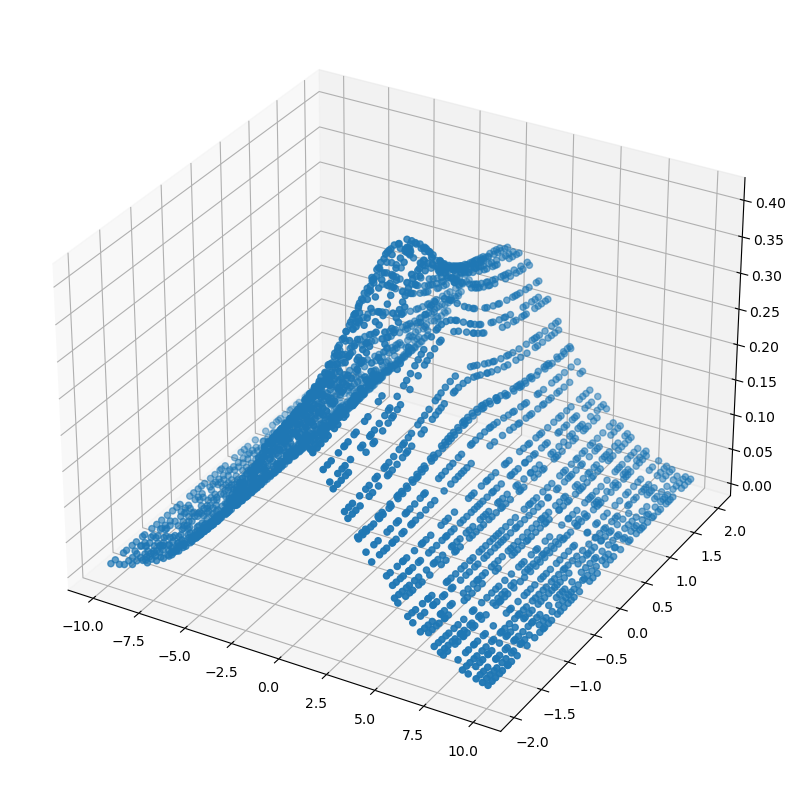

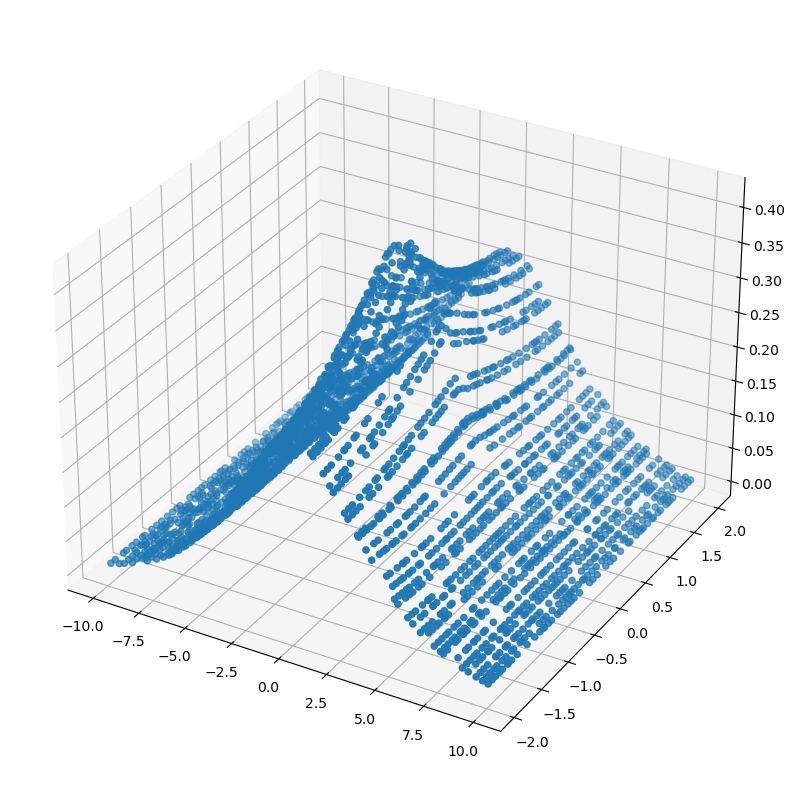

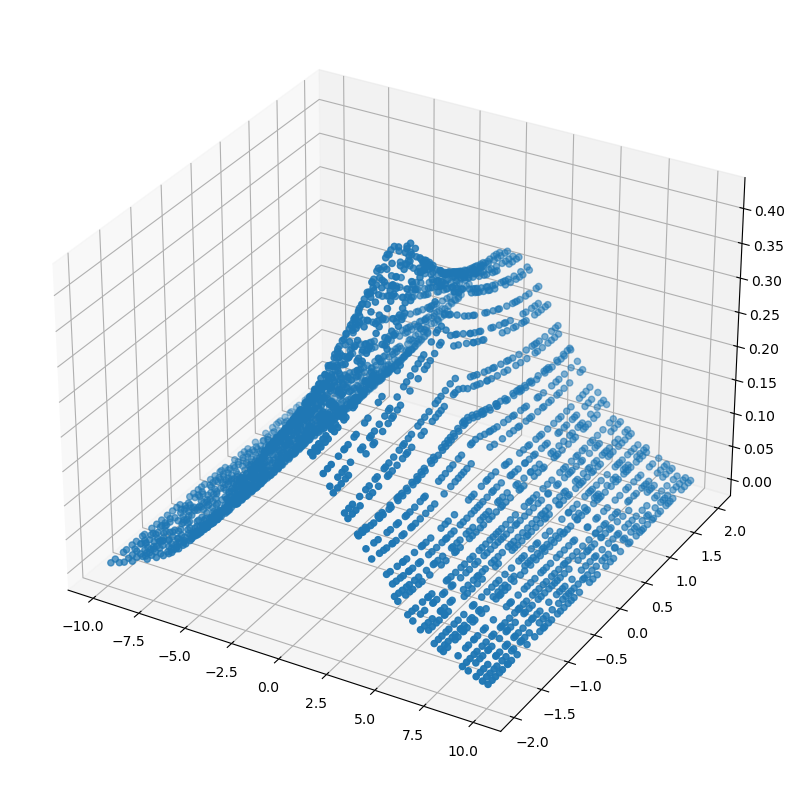

In [15]:
%%time
model.losshistory=[]            
model.train()

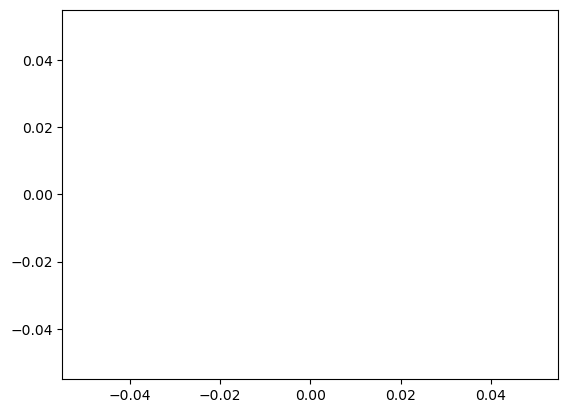

In [16]:
plt.plot(model.losshistory)

In [17]:
u00_1, v00_1, u00_2, v00_2 = model.predict1(test10_x,test10_t)
u11_1, v11_1, u11_2, v11_2 = model.predict1(testb_t1,testb_x1)
u22_1, v22_1, u22_2, v22_2 = model.predict1(testb_t2,testb_x2)
a1,b1,c1,d1, ux11_1, vx11_1, ux11_2, vx11_2 = model.predict2(testb_t1,testb_x1)
a1,b1,c1,d1, ux22_1, vx22_1, ux22_2, vx22_2 = model.predict2(testb_t2,testb_x2)

f1, f2, f3, f4,a1,b1,c1,d1 = model.predict2(testu_x,testu_t)     

C:\Users\npofsi\AppData\Local\Temp\ipykernel_18624\4110178622.py:267: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_18624\4110178622.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(Y, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_18624\4110178622.py:280: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\App

In [18]:
error_u0= ((np.linalg.norm(test10_r - u00_1, 2))**2+(np.linalg.norm(test10_c - v00_1, 2))**2+(np.linalg.norm(test20_r - u00_2, 2))**2+(np.linalg.norm(test20_c - v00_2, 2))**2)/20
error_ub= ((np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2+(np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2)/20
error_ubx= (
    (np.linalg.norm(ux11_1.cpu().detach().numpy() - ux22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_1.cpu().detach().numpy() - vx22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(ux11_2.cpu().detach().numpy() - ux22_2.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_2.cpu().detach().numpy() - vx22_2.cpu().detach().numpy(), 2))**2)/20

error_f= ((np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2+(np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2)/2000
print('Error_u0: %.5e, Error_ub: %.5e, Error_ubx: %.5e, Error_f: %.5e' % (error_u0.item(), error_ub.item(), error_ubx.item(), error_f.item()))




Error_u0: 8.02678e-06, Error_ub: 3.26097e-09, Error_ubx: 2.78250e-06, Error_f: 3.60012e-06


Using backend: tensorflow.compat.v1



c:\tools\Anaconda3\python.exe
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.


[[ 2318]
 [18361]
 [   12]
 ...
 [ 2059]
 [  737]
 [  590]]


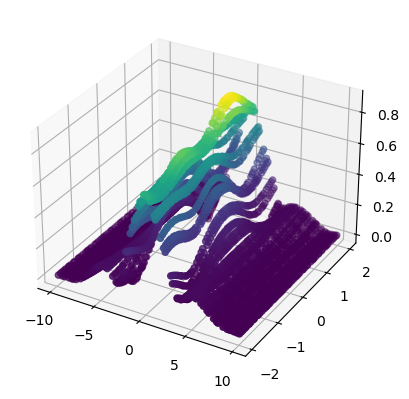

In [19]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
x_lower = -10   
x_upper = 10
t_lower = -2
t_upper =2

u00_1, v00_1, u00_2, v00_2 = model.predict1(hf_x,hf_t)
bx = plt.axes(projection='3d')
b=u00_1**2+v00_1**2
c=min(b)
d=b/c
d=d.astype(int)
print(d) 
bx.scatter3D(hf_x,hf_t,np.sqrt(b),c=d[:]/10)


In [20]:
# 用于绘图
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
x_lower = -10
x_upper = 10
t_lower = -2
t_upper =2

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.arange(-10, 10, 0.01)
T = np.arange(-2, 2, 0.01)
x, t = np.meshgrid(X, T)
i=1j
a=0
b=0.5
theta=0
delta=0
t=0
x=0
q1=(np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-t)+1j*a*x+1j*theta)/np.cosh(b*x-2*a*b*t+delta))
print(q1)
q1=(np.sqrt(2)*0.5*np.exp(1j*0.25*t)/np.cosh(0.5*x))
q2=(1j*np.sqrt(2)*0.5*np.exp(1j*0.25*t)/np.cosh(0.5*x))
# q2=(1j*np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-t)+1j*a*x+1j*theta)/np.cosh(b*x-2*a*b*t+delta))
# q1=(np.sqrt(2)*np.exp(1j*t)/np.cosh(x))
# q2=(1j*np.sqrt(2)*np.exp(1j*t)/np.cosh(x))

# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(2, 1, 1, projection='3d')

# #time.sleep(1)
# #fig, ax = plt.subplots(3)
# surf = ax.plot_surface(x,t,np.abs(q1), rstride=1, cstride=1, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# ax = fig.add_subplot(2, 1, 2, projection='3d')
# surf = ax.plot_surface(x,t,q1.real, rstride=1, cstride=1, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)


(0.7071067811865476+0j)


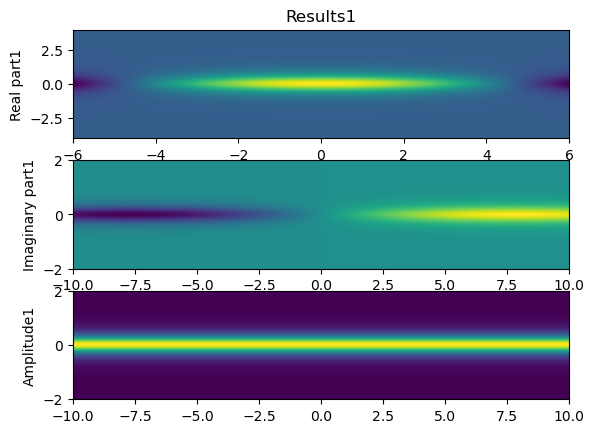

In [21]:
X = np.arange(-10, 10, 0.01)
T = np.arange(-2, 2, 0.01)
x, t = np.meshgrid(X, T)
i=1j
a=0
b=1
theta=0
delta=0
q1=(np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-t)+1j*a*x+1j*theta)/np.cosh(b*x-2*a*b*t+delta))
q11=q1.transpose()
q2=(-1j*np.sqrt(2)*b*np.exp(1j*(a**2-b**2)*(-t)+1j*a*x+1j*theta)/np.cosh(b*x-2*a*b*t+delta))
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    q11.real,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[ -6,6,-4,4], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    q11.imag,
    interpolation="nearest",
    cmap="viridis",
    extent=[ -10,10,-2,2],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    np.abs(q11),
    interpolation="nearest",
    cmap="viridis",
    extent=[ x_lower, x_upper,t_lower, t_upper],
    origin="lower",
    aspect="auto",
)

(205824, 1)
[[328]
 [345]
 [362]
 ...
 [558]
 [584]
 [608]]


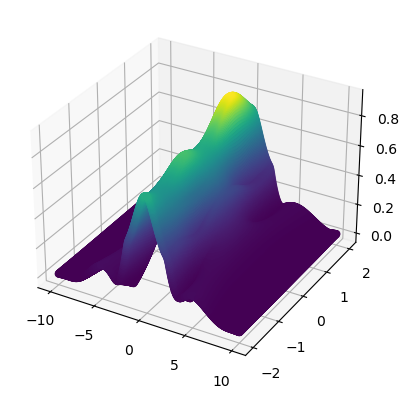

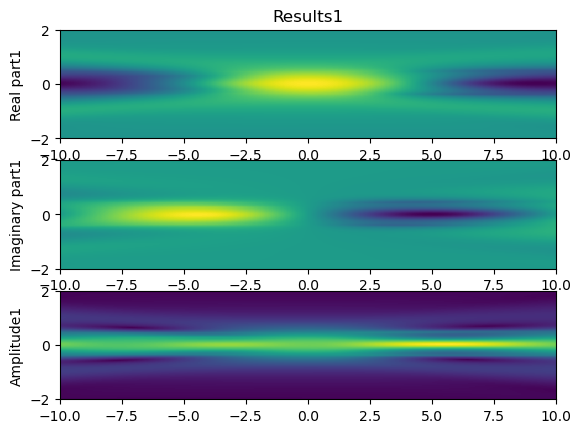

In [22]:
#周期性边界条件
x_lower = -10
x_upper = 10
t_lower = -2
t_upper =2

x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)
hf= np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
hf_x=hf[:,[0]]
hf_t=hf[:,[1]]
u0_1, v0_1, u0_2, v0_2 = model.predict1(hf_x,hf_t)
print(u0_1.shape)
u1=np.reshape(u0_1,(402,512))
u11=u1.transpose()
v1=np.reshape(v0_1,(402,512))
v11=v1.transpose()
h1=np.sqrt(u11**2+v11**2)
bx = plt.axes(projection='3d')
b=u0_1**2+v0_1**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(hf_x,hf_t,np.sqrt(b),c=d[:]/10)

fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u11,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[ x_lower, x_upper,t_lower, t_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v11,
    interpolation="nearest",
    cmap="viridis",
    extent=[ x_lower, x_upper,t_lower, t_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1,
    interpolation="nearest",
    cmap="viridis",
    extent=[ x_lower, x_upper,t_lower, t_upper],
    origin="lower",
    aspect="auto",
)